In [313]:
# from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.common.desired_capabilities import DesiredCapabilities
from selenium.webdriver.chrome.options import Options
import os
import json
import re
import datetime
import sys
import pandas as pd
from datetime import datetime
import time
import numpy as np
import matplotlib.pyplot as plt




try: 
    from pyvirtualdisplay import Display
except  ModuleNotFoundError:
    !pip install PyVirtualDisplay
    
try: 
    from seleniumwire import webdriver  # Import from seleniumwire
except  ModuleNotFoundError:
    print("module selenium-wire is not installed, now start installation.")
    !pip install selenium-wire

Exception in thread ServerThread (('::ffff:127.0.0.1', 65185, 0, 0)):
Traceback (most recent call last):
  File "/Users/francis/opt/anaconda3/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seleniumwire/thirdparty/mitmproxy/master.py", line 31, in run
    self.server.serve_forever()
  File "/Users/francis/opt/anaconda3/lib/python3.7/site-packages/seleniumwire/thirdparty/mitmproxy/net/tcp.py", line 622, in serve_forever
    connection, client_address = self.socket.accept()
  File "/Users/francis/opt/anaconda3/lib/python3.7/socket.py", line 212, in accept
    fd, addr = self._accept()
OSError: [Errno 24] Too many open files
Unhandled exception in thread started by <bound method Thread._bootstrap of <ServerThread(ServerThread (('::ffff:127.0.0.1', 65185, 0, 0)), started daemon 123145745555456)>>


In [314]:
# For mouse scroll
def wheel_element(element, deltaX = 0, deltaY = 120, offsetX = 0, offsetY = 0):
    error = element._parent.execute_script("""
    var element = arguments[0];
    var deltaX = arguments[1]
    var deltaY = arguments[2];
    var box = element.getBoundingClientRect();
    var clientX = box.left + (arguments[3] || box.width / 2);
    var clientY = box.top + (arguments[4] || box.height / 2);
    var target = element.ownerDocument.elementFromPoint(clientX, clientY);

    for (var e = target; e; e = e.parentElement) {
      if (e === element) {
        target.dispatchEvent(new MouseEvent('mouseover', {view: window, bubbles: true, cancelable: true, clientX: clientX, clientY: clientY}));
        target.dispatchEvent(new MouseEvent('mousemove', {view: window, bubbles: true, cancelable: true, clientX: clientX, clientY: clientY}));
        target.dispatchEvent(new WheelEvent('wheel',     {view: window, bubbles: true, cancelable: true, clientX: clientX, clientY: clientY, deltaX: deltaX, deltaY: deltaY}));
        return;
      }
    }    
    return "Element is not interactable";
    """, element, deltaX, deltaY, offsetY)

def process_browser_log_entry(entry):
    response = json.loads(entry['message'])['message']
    return response

In [445]:
def getBinanceWebsocketPriceData(url, verbose=False):
    chrm_options = Options()
    chrm_caps = webdriver.DesiredCapabilities.CHROME.copy()
    chrm_caps['goog:loggingPrefs'] = { 'performance':'ALL' } #save all returns including websocket data

    monitor=True

    if monitor == False:
        display = Display(visible=0, size=(1024, 768)) 
        display.start()

    driver = webdriver.Chrome(chrome_options=chrm_options,
                              desired_capabilities=chrm_caps) 

    driver.maximize_window()
    
    # Go to Trading View
    website = url
    driver.get(website)
    print('Reached tradingview website')

    # Input query
    driver.find_element_by_tag_name('body').send_keys(Keys.COMMAND + 'k')
    driver.implicitly_wait(3)

    driver.find_element_by_id('onetrust-reject-all-handler').click()
    driver.implicitly_wait(1)

    # click 1 hour interval
    dataStartTs = datetime.now().timestamp() # save the timestamp of time right before clicking the button for filtering 
    driver.find_element_by_id('1h').click()

    # scroll
    elm = driver.find_element_by_name('chart')
    for i in range(50):
        wheel_element(elm, deltaX=0, deltaY=50)
    
    time.sleep(1)

    for i in range(2400): # 1500 is approximately 1.25 years
        wheel_element(elm, deltaX=-50, deltaY=0)
        time.sleep(0.1)
        
    try:                   
        browser_log = driver.get_log('performance') 
        events = [process_browser_log_entry(entry) for entry in browser_log if entry['timestamp']> dataStartTs]
        events = [event for event in events if 'Network.response' in event['method']]
        
        # parse
        _id = []
        for i, event in enumerate(events):
            try:
                if event['params']['headers']['content-type'] == 'application/json': # price data to be plotted on chart are transmitted in json
                    _id.append(i) 
            except:
                continue

        # get requestionId 
        requestId_arr = [events[i]['params']['requestId'] for i in _id]

        # get response
        response_arr = []
        for requestId in requestId_arr:
            response_arr.append(driver.execute_cdp_cmd('Network.getResponseBody',
                               {'requestId': requestId}))

        # filter out price data; they are stored as list
        priceData_arr = []
        for response in response_arr:
            j = json.loads(response['body'])
            if type(j) == list:
                if type(j[0])==list:
                    priceData_arr.append(j)
        print('done')
        
        if verbose:
            return priceData_arr, browser_log

        else:
            return priceData_arr
        
    except:
        if verbose:
            print('error')
            return None, (browser_log, response_arr)
        else:
            return None, None


In [446]:
url = 'https://www.binance.com/en/futures/btcusdt_quarter?utm_source=internal&utm_medium=homepage&utm_campaign=trading_dashboard'
url = 'https://www.binance.com/en/delivery/btcusd_bi-quarter?utm_source=internal&utm_medium=homepage&utm_campaign=trading_dashboard'
results, log = getBinanceWebsocketPriceData(url, True)

Reached tradingview website
done


In [447]:
to_df = []
for result in results:
    _df = pd.DataFrame(result)
    _m = np.mean(_df.loc[:,0].diff())
    if _m == 3600000:
        to_df.append(_df)

df = pd.concat(to_df,
          axis=0, ignore_index=True)
# df.drop_duplicates(0, keep='last', inplace=True)

In [448]:
len(to_df)
# len(results)

176

In [449]:
df.iloc[:,0] = pd.to_datetime(df.iloc[:,0]*1000_000)
df.iloc[:,1:] = df.iloc[:,1:].astype(float)
df = df.sort_values(0)

In [450]:
df.drop_duplicates(0, keep='last', inplace=True)
df.reset_index(drop=True, inplace=True)

In [451]:
col_names = ['dateTime', 'open', 'high', 'low', 'close', 'volume', 'closeTime', 'quoteAssetVolume', 'numberOfTrades', 
 'takerBuyVolume', 'takerBuyQuoteAssetVolume', 'Ignore']

In [452]:
df.columns = col_names

In [457]:
# check missing data
np.mean(df.dateTime.diff())

Timedelta('0 days 01:00:00')

/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/francis/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional in

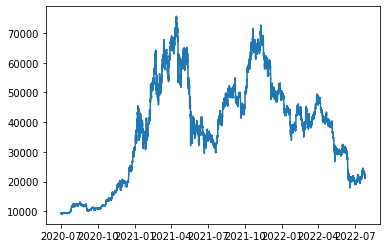

In [458]:
plt.plot(df.dateTime, df.open)